In [1]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import Model

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

In [ ]:
# for file_name in os.listdir(source_folder):
#     # construct full file path
#     source = source_folder + file_name
#     destination = destination_folder + file_name
#     # copy only files
#     if os.path.isfile(source):
#         shutil.copyfile(source, destination)
#         print('copied', file_name)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
source_path_pria = '/content/drive/MyDrive/data_gender/Pria'
source_path_wanita = '/content/drive/MyDrive/data_gender/Wanita'
# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_pria))} images of pria.")
print(f"There are {len(os.listdir(source_path_wanita))} images of wanita.")

There are 727 images of pria.
There are 1089 images of wanita.


In [6]:
# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(source_path_pria, os.listdir(source_path_pria)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (1350, 1080, 3)
The maximum pixel value used is: 255.0


In [7]:
base_dir = '/content/drive/MyDrive/data_gender/'

In [8]:
train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range = 0.2,
                        fill_mode = 'nearest',
                        validation_split=0.2,
                        )

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
training_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (256, 256),
    shuffle = True,
    class_mode = 'categorical',
    subset = 'training'
)
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (256, 256),
    shuffle = True,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 1453 images belonging to 2 classes.
Found 362 images belonging to 2 classes.


In [11]:
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = 'imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [12]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
# pre_trained_model.summary()

In [19]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)              

x = layers.Dense(512, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.95:
            print("\nReached 95.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
# last_desired_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_desired_layer.output_shape)
# last_output = last_desired_layer.output
# print('last layer output: ', last_output)

In [ ]:
# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(pre_trained_model.output)
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu')(x)
# # Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# # Add a final sigmoid layer for classification
# x = layers.Dense  (1, activation='sigmoid')(x)           

# # Append the dense network to the base model
# model = Model(pre_trained_model.input, x) 

In [26]:
model.compile(optimizer= RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
callbacks = myCallback()
history = model.fit(
    training_generator,
    epochs=100, 
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=4,  
    verbose=2,
    callbacks=[callbacks]
    )

Epoch 1/100
46/46 - 68s - loss: 0.3381 - accuracy: 0.8328 - val_loss: 0.3090 - val_accuracy: 0.8750 - 68s/epoch - 1s/step
Epoch 2/100
46/46 - 60s - loss: 0.3277 - accuracy: 0.8211 - val_loss: 0.3473 - val_accuracy: 0.8594 - 60s/epoch - 1s/step
Epoch 3/100
46/46 - 61s - loss: 0.3022 - accuracy: 0.8376 - val_loss: 0.2976 - val_accuracy: 0.8594 - 61s/epoch - 1s/step
Epoch 4/100
46/46 - 60s - loss: 0.3219 - accuracy: 0.8472 - val_loss: 0.2473 - val_accuracy: 0.8906 - 60s/epoch - 1s/step
Epoch 5/100
46/46 - 62s - loss: 0.2957 - accuracy: 0.8507 - val_loss: 0.4735 - val_accuracy: 0.7969 - 62s/epoch - 1s/step
Epoch 6/100
46/46 - 61s - loss: 0.2737 - accuracy: 0.8720 - val_loss: 0.3164 - val_accuracy: 0.8359 - 61s/epoch - 1s/step
Epoch 7/100
46/46 - 61s - loss: 0.2985 - accuracy: 0.8651 - val_loss: 0.3796 - val_accuracy: 0.8594 - 61s/epoch - 1s/step
Epoch 8/100
46/46 - 61s - loss: 0.2952 - accuracy: 0.8658 - val_loss: 0.3084 - val_accuracy: 0.8438 - 61s/epoch - 1s/step
Epoch 9/100
46/46 - 59s 

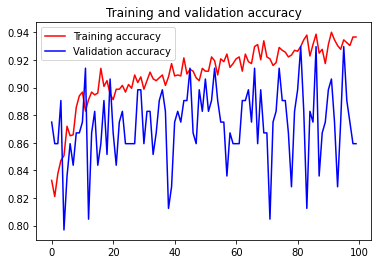

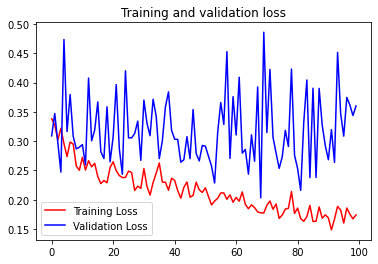

In [28]:
import matplotlib.pyplot as plt

# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
model.save('/content/drive/MyDrive/model_incpV3.h5')

In [ ]:
# import numpy as np
# from google.colab import files
# from keras.preprocessing import image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# %matplotlib inline
     

In [ ]:
# def testing_image(image_directory):
#     test_image = image.load_img(image_directory, target_size = (256, 256))
#     test_image = image.img_to_array(test_image)
#     test_image = np.expand_dims(test_image, axis = 0)
# #Changes in code
#     pred = model.predict(test_image)
#     result = np.where(pred > 0.5, 1, 0) #<--to get the binary category
#     print(pred)
#     print(result)
# testing_image('/content/drive/MyDrive/data_gender/Pria/100_2.jpg')